In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pandas_profiling as pf
import warnings
import gc
import re
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from time import process_time
import shap
import lime
import lime.lime_tabular

In [167]:
dataset=pd.read_csv("Car details v3.csv")
pf.ProfileReport(dataset)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df = dataset.copy(deep=True)
df.drop_duplicates(subset=None, keep='first', inplace=True)
df=df.dropna(axis=0)

#this results in 222 observations out of 8128 getting dropped

Text(0, 0.5, 'Data type')

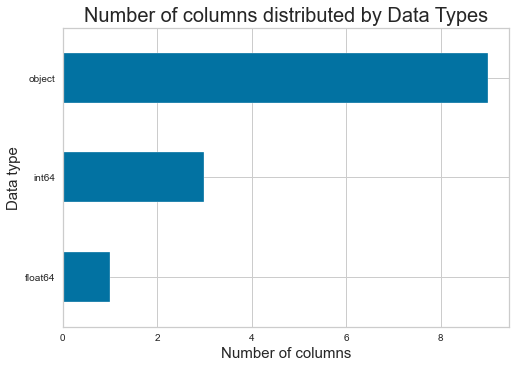

In [3]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [148]:
x=df.drop(['selling_price'], axis=1)
y=np.log(df['selling_price'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17)

#  Data Cleansing & Feature Engineering
transform the y to log(y) to handle strong positive right skewness
km_driven has strong positive right skew, try a transformation as log has resulted in negative skewness
drop observations with missing values (should be 221 odd out of 8128) & duplicate records(1k odd available records shd be 6845)
mileage, engine, max_power extract numerals from strings
age of the vehicle has to be derived 
ownership has to be ordinally labelled (dummy encoded as ordinality is tricky)
maker, brand & variant name derivation - useless
category derivation (suv, sedan, hatchback et al) - not doing it for now
drop torque variable
significant variables: mileage, age, km_driven, max_power, seats, owner_first owner, fuel_petrol

In [149]:
x_train['age']=dt.date.today().year - x_train['year']
x_test['age']=dt.date.today().year - x_test['year']

x_train['mileage'] = x_train["mileage"].str.extract("(\d*\.?\d+)", expand=True).astype(float)
x_test['mileage'] = x_test["mileage"].str.extract("(\d*\.?\d+)", expand=True).astype(float)
x_train['engine'] = x_train['engine'].str.rstrip('CC').astype(int)
x_test['engine'] = x_test['engine'].str.rstrip('CC').astype(int)
x_train['max_power'] = x_train['max_power'].str.rstrip('bhp').astype(float)
x_test['max_power'] = x_test['max_power'].str.rstrip('bhp').astype(float)

#x_train['make'] = x_train.name.str.split().str.get(0)
#x_train['brand'] = x_train.name.str.split().str.get(1)
#x_test['make'] = x_test.name.str.split().str.get(0)
#x_test['brand'] = x_test.name.str.split().str.get(1)

x_train=pd.get_dummies(x_train, prefix=['owner'], columns=['owner'])
x_train=x_train.drop(['owner_Test Drive Car'],axis=1)
x_test=pd.get_dummies(x_test, prefix=['owner'], columns=['owner'])
x_test=x_test.drop(['owner_Test Drive Car'],axis=1)
x_train=pd.get_dummies(x_train, prefix=['fuel'], columns=['fuel'])
x_train=x_train.drop(['fuel_LPG'],axis=1)
x_test=pd.get_dummies(x_test, prefix=['fuel'], columns=['fuel'])
x_test=x_test.drop(['fuel_LPG'],axis=1)
x_train=pd.get_dummies(x_train, prefix=['seller_type'], columns=['seller_type'])
x_train=x_train.drop(['seller_type_Trustmark Dealer'],axis=1)
x_test=pd.get_dummies(x_test, prefix=['seller_type'], columns=['seller_type'])
x_test=x_test.drop(['seller_type_Trustmark Dealer'],axis=1)
x_train=pd.get_dummies(x_train, prefix=['transmission'], columns=['transmission'])
x_train=x_train.drop(['transmission_Automatic'],axis=1)
x_test=pd.get_dummies(x_test, prefix=['transmission'], columns=['transmission'])
x_test=x_test.drop(['transmission_Automatic'],axis=1)

x_train=x_train.drop(['name','torque','year'],axis=1)
x_test=x_test.drop(['name','torque','year'],axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [150]:
regr=LinearRegression()
linreg=regr.fit(x_train,y_train)
y_pred=linreg.predict(x_test)
print(linreg.score(x_test,y_test))
print('MAE is :',mean_absolute_error(y_test,y_pred))
print('MAPE is :',mean_absolute_percentage_error(y_test,y_pred))
print('MSE is :',mean_squared_error(y_test,y_pred))
print('RMSE is :',mean_squared_error(y_test,y_pred)**(1/2))
print('R-Squared is :',r2_score(y_test,y_pred))

0.8411020703825117
MAE is : 0.22974166396145732
MAPE is : 0.018029246442538394
MSE is : 0.09120343718619918
RMSE is : 0.30199906818763395
R-Squared is : 0.8411020703825117


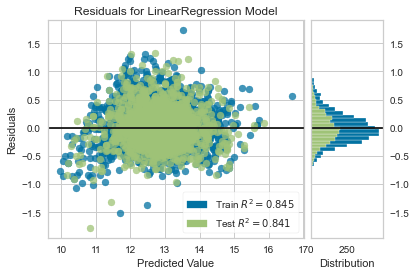

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [151]:
visualizer = ResidualsPlot(linreg)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [152]:
regr=RandomForestRegressor(max_depth=2, random_state=17, n_jobs=-1, n_estimators=1000, max_features='sqrt')
forreg=regr.fit(x_train, y_train)
print(forreg.score(x_test,y_test))
y_pred=forreg.predict(x_test)
print('MAE is :',mean_absolute_error(y_test,y_pred))
print('MAPE is :',mean_absolute_percentage_error(y_test,y_pred))
print('MSE is :',mean_squared_error(y_test,y_pred))
print('RMSE is :',mean_squared_error(y_test,y_pred)**(1/2))
print('R-Squared is :',r2_score(y_test,y_pred))

0.591744166001247
MAE is : 0.35185454530580323
MAPE is : 0.027484028661020614
MSE is : 0.23432863726820174
RMSE is : 0.4840750326841922
R-Squared is : 0.5917441660012467


In [153]:
params = {'n_estimators': 1000,
           'max_depth':3,
          'min_samples_split': 5,
          'subsample' : 0.8,
          'learning_rate': 0.1
         }
grdesreg=ensemble.GradientBoostingRegressor(**params)
grdesreg.fit(x_train, y_train)
print(grdesreg.score(x_test,y_test))
y_pred=grdesreg.predict(x_test)
print('MAE is :',mean_absolute_error(y_test,y_pred))
print('MAPE is :',mean_absolute_percentage_error(y_test,y_pred))
print('MSE is :',mean_squared_error(y_test,y_pred))
print('RMSE is :',mean_squared_error(y_test,y_pred)**(1/2))
print('R-Squared is :',r2_score(y_test,y_pred))

0.9140200385720416
MAE is : 0.15842427878092827
MAPE is : 0.012489647559779238
MSE is : 0.04935034729680693
RMSE is : 0.2221493805906443
R-Squared is : 0.9140200385720416


In [154]:
params = {'n_estimators': [int(x) for x in np.linspace(start=800,stop=1000,num=20)],
          'max_depth':range(3,5,1),
          'min_child_weight':range(3,9,2),
         }

t1_start=process_time()
xgbr=xgb.XGBRegressor(learning_rate=0.1)
xgbr_randomcv=RandomizedSearchCV(estimator=xgbr,param_distributions=params,cv=5,verbose=2,
                              random_state=17,n_jobs=1)
xgbr_randomcv.fit(x_train,y_train)
t1_stop=process_time()
print("Time Lapsed: ",t1_stop-t1_start)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=957; total time=   2.8s
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=957; total time=   2.6s
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=957; total time=   2.6s
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=957; total time=   2.9s
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=957; total time=   2.7s
[CV] END ..max_depth=3, min_child_weight=3, n_estimators=894; total time=   2.4s
[CV] END ..max_depth=3, min_child_weight=3, n_estimators=894; total time=   2.6s
[CV] END ..max_depth=3, min_child_weight=3, n_estimators=894; total time=   2.6s
[CV] END ..max_depth=3, min_child_weight=3, n_estimators=894; total time=   2.7s
[CV] END ..max_depth=3, min_child_weight=3, n_estimators=894; total time=   3.2s
[CV] END ..max_depth=3, min_child_weight=7, n_estimators=926; total time=   2.7s
[CV] END ..max_depth=3, min_child_weight=7, n_es

In [155]:
xgbr_randomcv.best_params_
xgbr_randomcv.best_estimator_
best_random_grid=xgbr_randomcv.best_estimator_
best_random_grid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=947, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [156]:
y_pred=best_random_grid.predict(x_test)
print('MAE is :',mean_absolute_error(y_test,y_pred))
print('MAPE is :',mean_absolute_percentage_error(y_test,y_pred))
print('MSE is :',mean_squared_error(y_test,y_pred))
print('RMSE is :',mean_squared_error(y_test,y_pred)**(1/2))
print('R-Squared is :',r2_score(y_test,y_pred))

MAE is : 0.15895254311693635
MAPE is : 0.01252122465883316
MSE is : 0.04817103936661544
RMSE is : 0.21947901805552036
R-Squared is : 0.9160746715362176


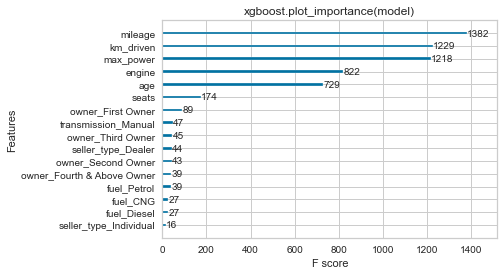

In [157]:
xgb.plot_importance(best_random_grid)
plt.title("xgboost.plot_importance(model)")
plt.show()

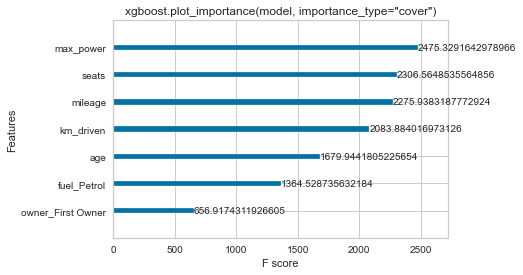

In [141]:
xgb.plot_importance(best_random_grid, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

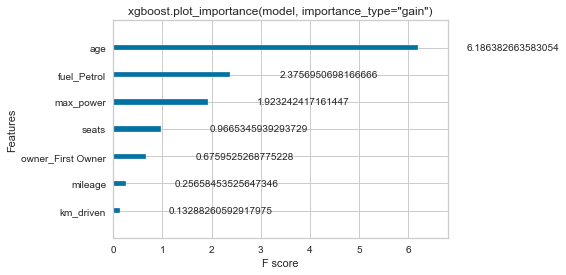

In [142]:
xgb.plot_importance(best_random_grid, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


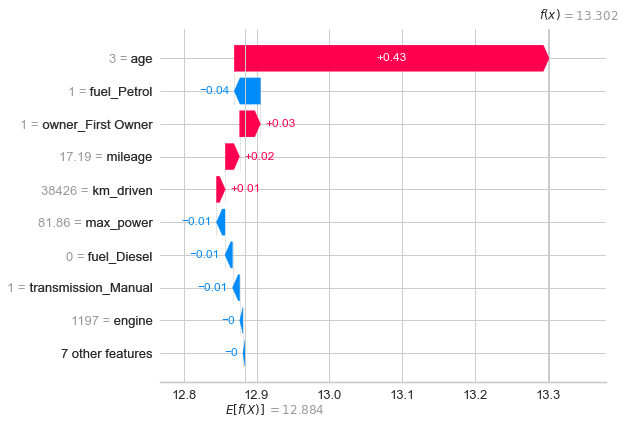

In [158]:
explainer = shap.Explainer(best_random_grid)
shap_values = explainer(x_test)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [159]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, verbose=True, mode="regression", feature_names=x_train.columns)

# storing a new observation
i = 2000
x_observation = x_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(x_observation.values[0], best_random_grid.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

Intercept 13.086140854223517
Prediction_local [11.53909337]
Right: 10.906456


0.5338712073275635


<AxesSubplot:xlabel='selling_price', ylabel='Density'>

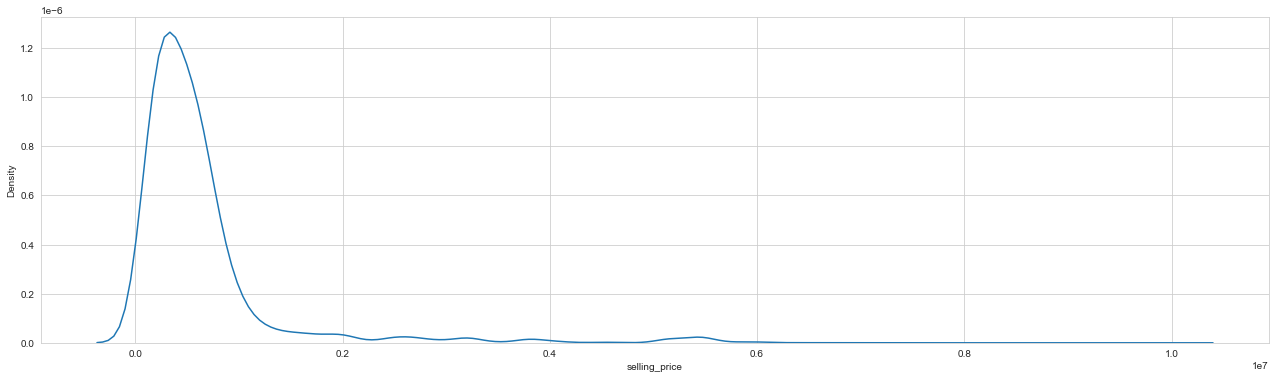

In [16]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df['selling_price'], label = 'selling_price')
print(reg.score(x_test,y_test))

In [19]:
df['selling_price'].skew()

4.193533440675855

In [37]:
df['km_driven'].skew()

11.170909783549087

<AxesSubplot:xlabel='km_driven', ylabel='Density'>

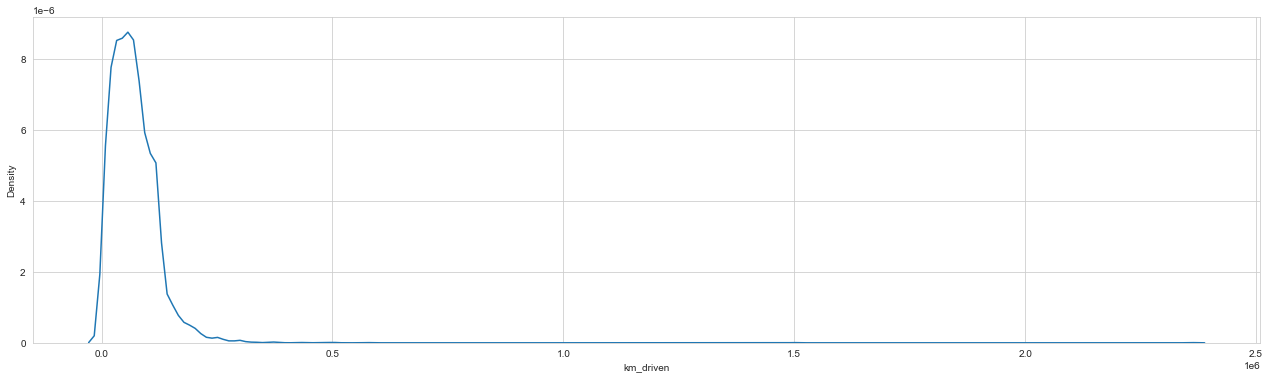

In [38]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df['km_driven'], label = 'kilometers driven')

In [20]:
sp_log=np.log(df['selling_price'])
sp_log.skew()

0.22325945669211808

In [119]:
kmd_log=np.log(df['km_driven'])
kmd_sqrt=np.sqrt(df['km_driven'])
kmd_inv=1/(df['km_driven'])
kmd_inv.skew()

C:\Users\remyaviswanathan\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Data must be positive.

In [121]:
skewed_features=['km_driven']
from scipy.stats import boxcox
for i in skewed_features:
    x_train[i],lmbda=boxcox(x_train[i], lmbda=None)

In [122]:
x_train['km_driven'].skew()

0.09631325909276857

<AxesSubplot:xlabel='km_driven', ylabel='Density'>

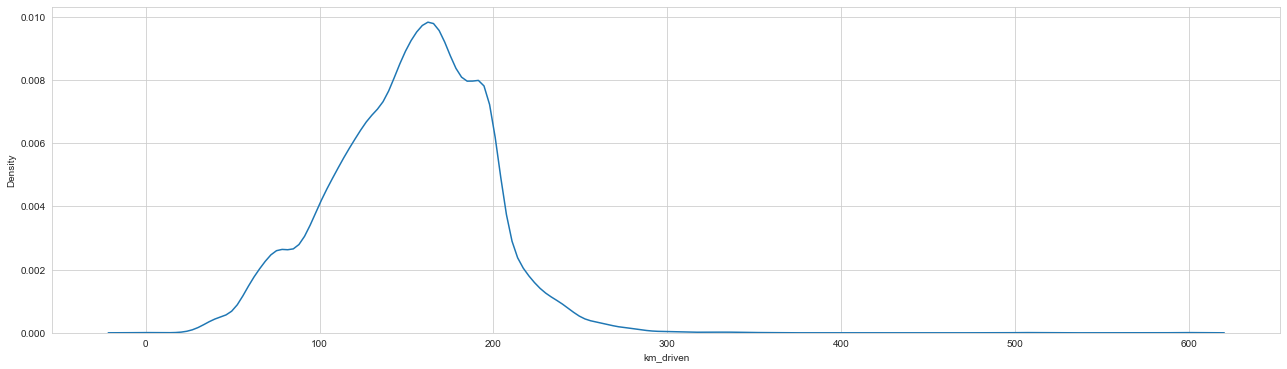

In [124]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df['km_driven'], label = 'box cox of kilometers driven')

<AxesSubplot:xlabel='km_driven', ylabel='Density'>

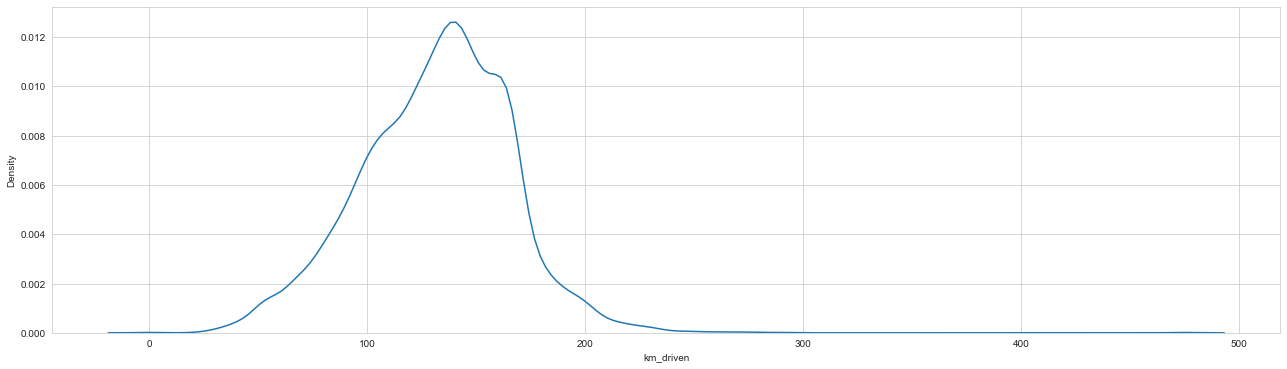

In [123]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(x_train['km_driven'], label = 'box cox of kilometers driven')

<AxesSubplot:xlabel='selling_price', ylabel='Density'>

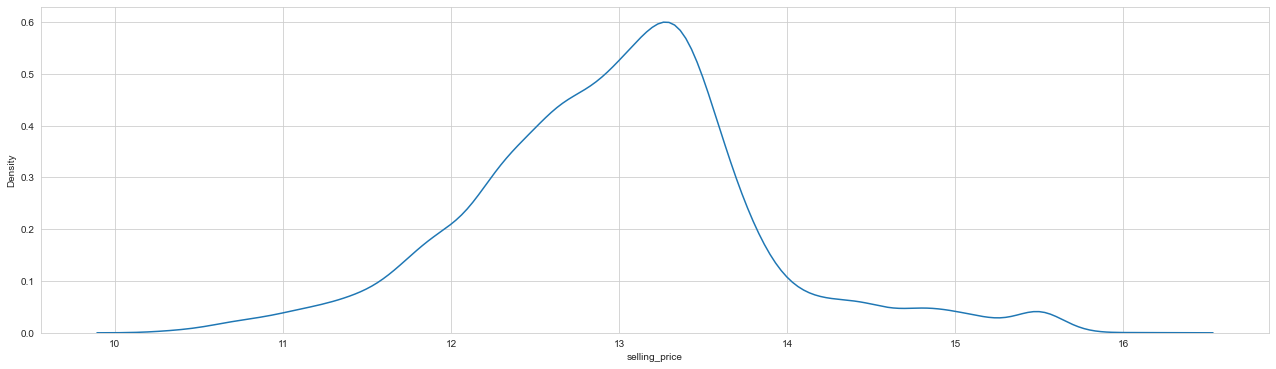

In [21]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(sp_log, label = 'log of selling_price')

In [15]:
tf.__version__

'2.6.0'

In [160]:
# Working out ANN on the dataset
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.fit_transform(x_test)

#initializing the ann
ann = tf.keras.models.Sequential()

#adding the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 2nd hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 3rd hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 4th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 5th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 6th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 7th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 8th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 9th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized
#adding the 10th hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu')) #units can be hyper paramterized

#adding the output layer
ann.add(tf.keras.layers.Dense(units=1)) #units can be hyper paramterized

#compiling the ann
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

#training ann on scaled train dataset
ann.fit(x_train_scaled, y_train, batch_size = 32, epochs = 250)

Epoch 1/250
147/147 [==============================] - 2s 2ms/step - loss: 157.5895
Epoch 2/250
147/147 [==============================] - 0s 2ms/step - loss: 51.1061
Epoch 3/250
147/147 [==============================] - 0s 2ms/step - loss: 2.5140
Epoch 4/250
147/147 [==============================] - 0s 2ms/step - loss: 1.2213
Epoch 5/250
147/147 [==============================] - 0s 2ms/step - loss: 0.7451
Epoch 6/250
147/147 [==============================] - 0s 2ms/step - loss: 0.5142
Epoch 7/250
147/147 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 8/250
147/147 [==============================] - 0s 2ms/step - loss: 0.3069
Epoch 9/250
147/147 [==============================] - 0s 2ms/step - loss: 0.2549
Epoch 10/250
147/147 [==============================] - 0s 2ms/step - loss: 0.2194
Epoch 11/250
147/147 [==============================] - 0s 2ms/step - loss: 0.1932
Epoch 12/250
147/147 [==============================] - 0s 2ms/step - loss: 0.1725
Epoch 13/2

147/147 [==============================] - 0s 2ms/step - loss: 0.0798
Epoch 197/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0788
Epoch 198/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0804
Epoch 199/250
147/147 [==============================] - 0s 3ms/step - loss: 0.0793
Epoch 200/250
147/147 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 201/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 202/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 203/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 204/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0803
Epoch 205/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 206/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0804
Epoch 207/250
147/147 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 

In [161]:
#making the prediction 1.double braces 2.scaling 3.reversing the variable transformation (exp in case of log)
print(np.exp((ann.predict(sc.transform([[44000,12.1,980,64,5,11,1,0,0,0,0,0,1,0,1,1]])))))

[[162331.3]]


In [162]:
y_pred = ann.predict(x_test_scaled)
print('MAE is :',mean_absolute_error(y_test,y_pred))
print('MAPE is :',mean_absolute_percentage_error(y_test,y_pred))
print('MSE is :',mean_squared_error(y_test,y_pred))
print('RMSE is :',mean_squared_error(y_test,y_pred)**(1/2))
print('R-Squared is :',r2_score(y_test,y_pred))

MAE is : 0.2298200951277246
MAPE is : 0.017965063106529063
MSE is : 0.08738136861024635
RMSE is : 0.2956033974944239
R-Squared is : 0.8477610166055041
